In [1]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import requests
import zipfile
from pathlib import Path

data_path = Path('data/')
image_path = data_path/'pizza_steak_sushi'

if image_path.is_dir():
    print('Skipping creating')
else:
    print('Creating one')
    image_path.mkdir(parents=True, exist_ok=True)
    
with open(data_path/'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('Downloading')
    f.write(request.content)
    
with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping')
    zip_ref.extractall(image_path)

Skipping creating
Downloading
Unzipping


In [3]:
import os

def walk_through_dir(dir_path):
    """Walks through dir path returning content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"{len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_path)

2 directories and 0 images in data\pizza_steak_sushi
3 directories and 0 images in data\pizza_steak_sushi\test
0 directories and 25 images in data\pizza_steak_sushi\test\pizza
0 directories and 19 images in data\pizza_steak_sushi\test\steak
0 directories and 31 images in data\pizza_steak_sushi\test\sushi
3 directories and 0 images in data\pizza_steak_sushi\train
0 directories and 78 images in data\pizza_steak_sushi\train\pizza
0 directories and 75 images in data\pizza_steak_sushi\train\steak
0 directories and 72 images in data\pizza_steak_sushi\train\sushi


In [4]:
train_dir = image_path/'train'
test_dir = image_path/'test'
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Image path: data\pizza_steak_sushi\test\sushi\858157.jpg
Image class: sushi


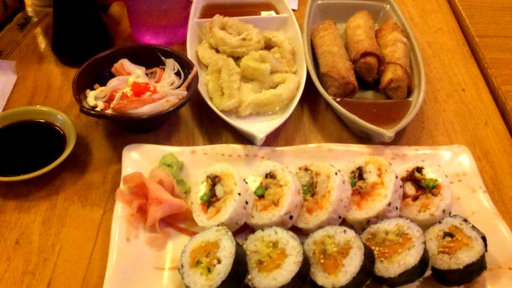

In [5]:
import random
from PIL import Image

# random.seed(42)

image_path_list = list(image_path.glob('*/*/*.jpg'))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print('Image path:', random_image_path)
print('Image class:', image_class)
img

(-0.5, 511.5, 287.5, -0.5)

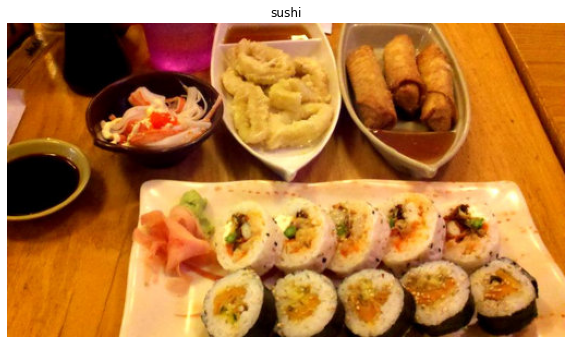

In [6]:
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_array)
plt.title(image_class)
plt.axis(False)

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

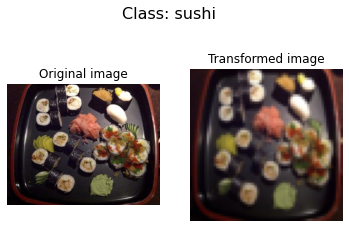

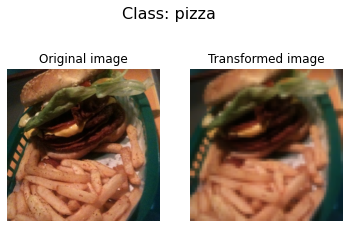

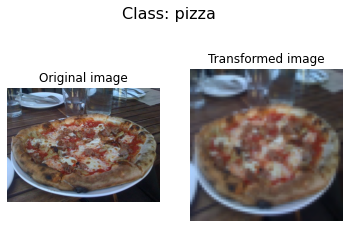

In [8]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """Selects random images, applies transforms, plots original vs transformed image"""
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title('Original image')
            ax[0].axis(False)
            
            transformed = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed)
            ax[1].set_title('Transformed image')
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            
plot_transformed_images(image_path_list, data_transform, n=3, seed=42)

## 1. Creating train dataset with ImageFolder

In [14]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, 
                                 transform=data_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform,
                                target_transform=None)

class_names = train_data.classes
class_dict = train_data.class_to_idx
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Permuted shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

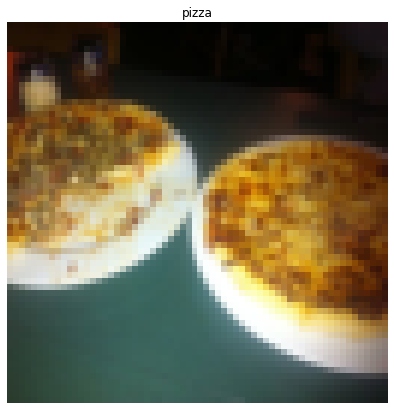

In [21]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")

img_permute = img.permute(1, 2, 0)
print(f"Permuted shape: {img_permute.shape}")

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label])

In [26]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


## 2. Loading image data with a custom dataset class

In [27]:
import os, pathlib, torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [32]:
def find_classes(directory)->Tuple[List[str], Dict[str, int]]:
    """Finds classes and maps them to numbers and returns them"""
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Could not find any classes")
    class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
        
    return classes, class_to_idx

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [51]:
from torch.utils.data import Dataset
from torchvision import transforms

class ImageFolderCustom(Dataset):
    def __init__(self, target_dir, transform=None):
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_dir)
    
    def load_image(self, index):
        img_path = self.paths[index]
        return Image.open(img_path)
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img = self.load_image(index)
        label = self.paths[index].parent.name
        class_idx = self.class_to_idx[label]
        
        if self.transform:
            img = self.transform(img)
        return img, class_idx
    
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
train_data_custom = ImageFolderCustom(train_dir, train_transforms)
test_data_custom = ImageFolderCustom(test_dir, test_transforms)

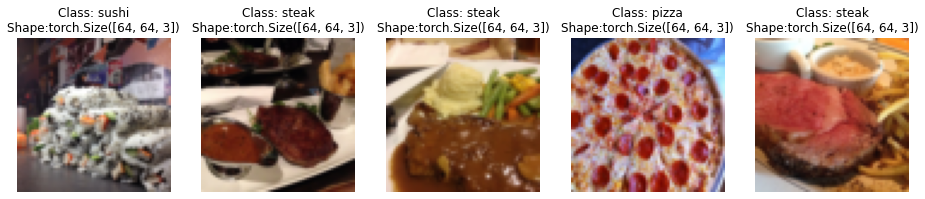

In [47]:
def display_random_images(dataset, classes=None, n=10, display_shape=True, seed=None):
    if n > 10:
        n = 10
        display_shape = False
    if seed:
        random.seed(seed)
    random_samples_idx = random.sample(range(len(dataset)), k=n) # from 0 to len(dataset) chooses k random numbers
    
    plt.figure(figsize=(16, 8))
    
    for i, target_sample in enumerate(random_samples_idx):
        target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]
        target_image = target_image.permute(1, 2, 0)
        plt.subplot(1, n, i+1)
        plt.imshow(target_image)
        plt.axis('off')
        if classes:
            title = f"Class: {classes[target_label]}"
            if display_shape:
                title = title + f"\nShape:{target_image.shape}"
            plt.title(title)
        
display_random_images(train_data, n=5, classes=class_names)

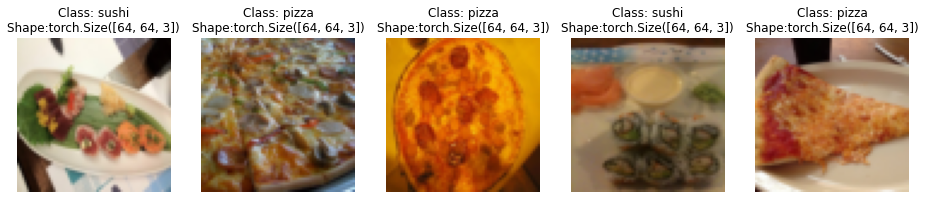

In [52]:
display_random_images(train_data_custom, n=5, classes=class_names)

In [60]:
from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(train_data_custom, batch_size=32, num_workers=0, shuffle=True)
test_dataloader_custom = DataLoader(test_data_custom, batch_size=32, num_workers=0, shuffle=False)

img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## Torchvision transforms

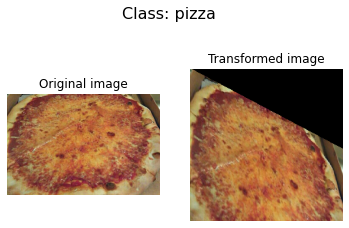

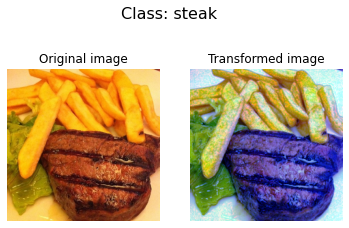

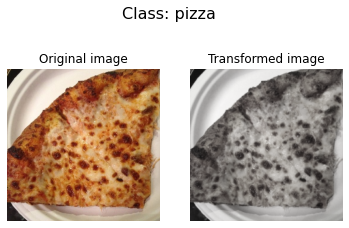

In [61]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # applies other transforms randomly
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_images(
    image_path_list,
    train_transform,
    n=3,
    seed=None
)

## Model development and training - TinyVGG